## Importing the libraries

In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
import scipy.stats as stats
import wandb
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier




In [207]:
df = pd.read_excel('/mnt/d/WSL/Flight-Fare-Prediction/Dataset/Data_Train.xlsx')
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Understanding the dataset

#### Imformation of the dataset

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


#### Shape of the dataset

In [209]:
rows, columns = df.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 10683
Number of columns: 11


#### Finding NULL Values in the dataset

In [210]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

#### Finding the column which has NaN Values
Since the number of null values or missing values are negligible so am removing it

In [211]:
df[df['Route'].isnull() | df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


#### Removing the NaN Values

In [212]:
df.dropna(inplace = True)

In [213]:
df.shape

(10682, 11)

#### Plotting the datatypes

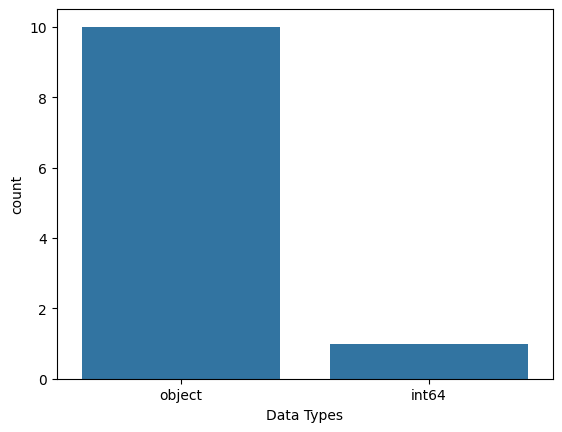

In [214]:
dtypes_df = pd.DataFrame(df.dtypes, columns=['Data Types'])

# Create a count plot
sns.countplot(x='Data Types', data=dtypes_df)
plt.show()

#### Statistical Interpretation

In [215]:
df.describe()

,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


#### Checking for duplicate rows and removing it

In [216]:
df.duplicated().sum()

220

In [217]:
df.drop_duplicates(inplace=True)

## Feature Engineering

#### Duration column

In [218]:
def convert_duration(Duration):
        if len(Duration.split()) == 2:          # the length of duration in 2, 9h 30m e.g
            # taking the hour value
            hours = int(Duration.split()[0][: -1])      # 0 means the part before the space and -1 to discard the character,  
            # taking the minutes value
            minutes = int(Duration.split()[1][: -1])    # 0 means the part before the space and -1 to discard the character, 
           # converting to minutes
            return hours * 60 + minutes
        else:
            # if just hour is present
            return int(Duration[: -1]) * 60
df['Duration'] = df['Duration'].apply(convert_duration)
df.rename(columns={'Duration': 'Duration (in mins)'}, inplace=True)

In [219]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration (in mins),Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662


#### Airlines

In [220]:
df['Airline'] =df['Airline'].str.replace("Vistara Premium economy", "Vistara")
df['Airline'] =df['Airline'].str.replace("Jet Airways Business", "Jet Airways")
df['Airline'] =df['Airline'].str.replace("Multiple carriers Premium economy", "Multiple carriers")

#### Date of Journey

In [221]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Day_of_Week'] = pd.to_datetime(df['Date_of_Journey']).dt.day_name()


In [222]:
# adding a feature as weekend
df['Weekend'] = df['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)

Constant features don't contribute meaningful information to the model, and including them in the prediction process might not be helpful. 
'year' column having the same value (2019) in every row, it doesn't provide any variation in the data,

In [223]:
# Extracting the days, months and years from the Date_of_Journey column
df['Day'] = df['Date_of_Journey'].dt.day
df['month'] = df['Date_of_Journey'].dt.month

df.drop('Date_of_Journey',axis = 1, inplace = True)     #dropping the column 
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration (in mins),Total_Stops,Additional_Info,Price,Day_of_Week,Weekend,Day,month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897,Sunday,1,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662,Wednesday,0,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882,Sunday,1,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218,Sunday,1,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1 stop,No info,13302,Friday,0,1,3


#### Total stops

In [224]:
df['Total_Stops'] = df['Total_Stops'].str.extract('(\d+)').astype(float)
df.rename(columns={'Total_Stops': 'Total_Stops'}, inplace=True)
df['Total_Stops'].fillna(0, inplace=True)

/tmp/ipykernel_717/57672341.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total_Stops'].fillna(0, inplace=True)


In [225]:
df['Total_Stops'].value_counts()

Total_Stops
1.0    5625
0.0    3475
2.0    1318
3.0      43
4.0       1
Name: count, dtype: int64

#### Additional Information

In [226]:
df['Additional_Info'].value_counts()

Additional_Info
No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [227]:
# I figured that this column is not that useful because almost 8000 people didnt provide additional info
df.drop('Additional_Info',axis = 1, inplace = True)  

#### Departure time

In [228]:
df['Dep_Time'] = df['Dep_Time'].str.extract(r'(\d{2}:\d{2})')
df['Dep_Hours'] = df['Dep_Time'].str[:2].astype(int)        # Extract hours from the string and convert to input
df['Dep_Minutes'] = df['Dep_Time'].str[3:].astype(int)      # Extract mins from the string and convert to input

df.drop('Dep_Time',axis = 1, inplace = True)     #dropping the column 

#### Arrival Time

In [229]:
df['Arrival_Time'] = df['Arrival_Time'].str.extract(r'(\d{2}:\d{2})')
df['Arv_Hours'] = df['Arrival_Time'].str[:2].astype(int)        # Extract hours from the string and convert to input
df['Arv_Minutes'] = df['Arrival_Time'].str[3:].astype(int)      # Extract mins from the string and convert to input

df.drop('Arrival_Time',axis = 1, inplace = True)     #dropping the column 

In [230]:
df.sample(5)

,Airline,Source,Destination,Route,Duration (in mins),Total_Stops,Price,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes
10403,Jet Airways,Banglore,New Delhi,BLR → MAA → DEL,375,1.0,12295,Tuesday,0,12,3,9,45,16,0
6234,Jet Airways,Delhi,Cochin,DEL → BOM → COK,885,1.0,12898,Tuesday,0,21,5,21,50,12,35
5144,Vistara,Banglore,Delhi,BLR → DEL,170,0.0,4668,Thursday,0,27,6,9,45,12,35
2251,Air India,Kolkata,Banglore,CCU → DEL → COK → BLR,1100,2.0,13873,Friday,0,24,5,7,0,1,20
8016,IndiGo,Delhi,Cochin,DEL → HYD → MAA → COK,565,2.0,6610,Wednesday,0,6,3,11,55,21,20


#### Routes

In [231]:
# Group by 'Route' and calculate the average price for each route
route_stats = df.groupby('Route')['Price'].agg(['count', 'mean']).reset_index()

# Rename the columns for clarity
route_stats.columns = ['Route', 'Count', 'Average_Price']

sorted_route_stats = route_stats.sort_values(by=['Average_Price', 'Count'], ascending=False)
sorted_route_stats

,Route,Count,Average_Price
44,BOM → DED → DEL → HYD,1,24115.000000
51,BOM → JDH → DEL → HYD,3,23867.000000
58,BOM → VNS → DEL → HYD,1,23528.000000
57,BOM → UDR → DEL → HYD,1,22950.000000
38,BOM → BDQ → DEL → HYD,2,22792.500000
...,...,...,...
80,CCU → HYD → BLR,53,4910.018868
127,MAA → CCU,381,4789.892388
64,CCU → BLR,724,4556.055249
55,BOM → NDC → HYD,1,4140.000000


In [232]:
unique_values_count = df['Route'].value_counts()
print(unique_values_count)

Route
DEL → BOM → COK          2376
BLR → DEL                1536
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: count, Length: 128, dtype: int64


In [233]:
df.drop('Route',axis = 1, inplace = True)  

#### Putting the price columns as our last because its the target

In [234]:
price_column = df.pop('Price')
df['Price'] = price_column

In [235]:
df.sample(5)

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
8129,Multiple carriers,Delhi,Cochin,455,1.0,Friday,0,24,5,14,55,22,30,7740
5747,Air India,Kolkata,Banglore,1435,1.0,Sunday,1,24,3,20,30,20,25,12173
6097,Air India,Banglore,New Delhi,790,1.0,Sunday,1,3,3,8,15,21,25,6781
4150,Jet Airways,Delhi,Cochin,1505,1.0,Monday,0,27,5,11,30,12,35,12898
7457,IndiGo,Delhi,Cochin,630,1.0,Wednesday,0,12,6,15,0,1,30,5684


## Exploratory Data Analysis

#### Univariate

(A) Categorical Values

Text(0.5, 1.0, 'Month Distribution')

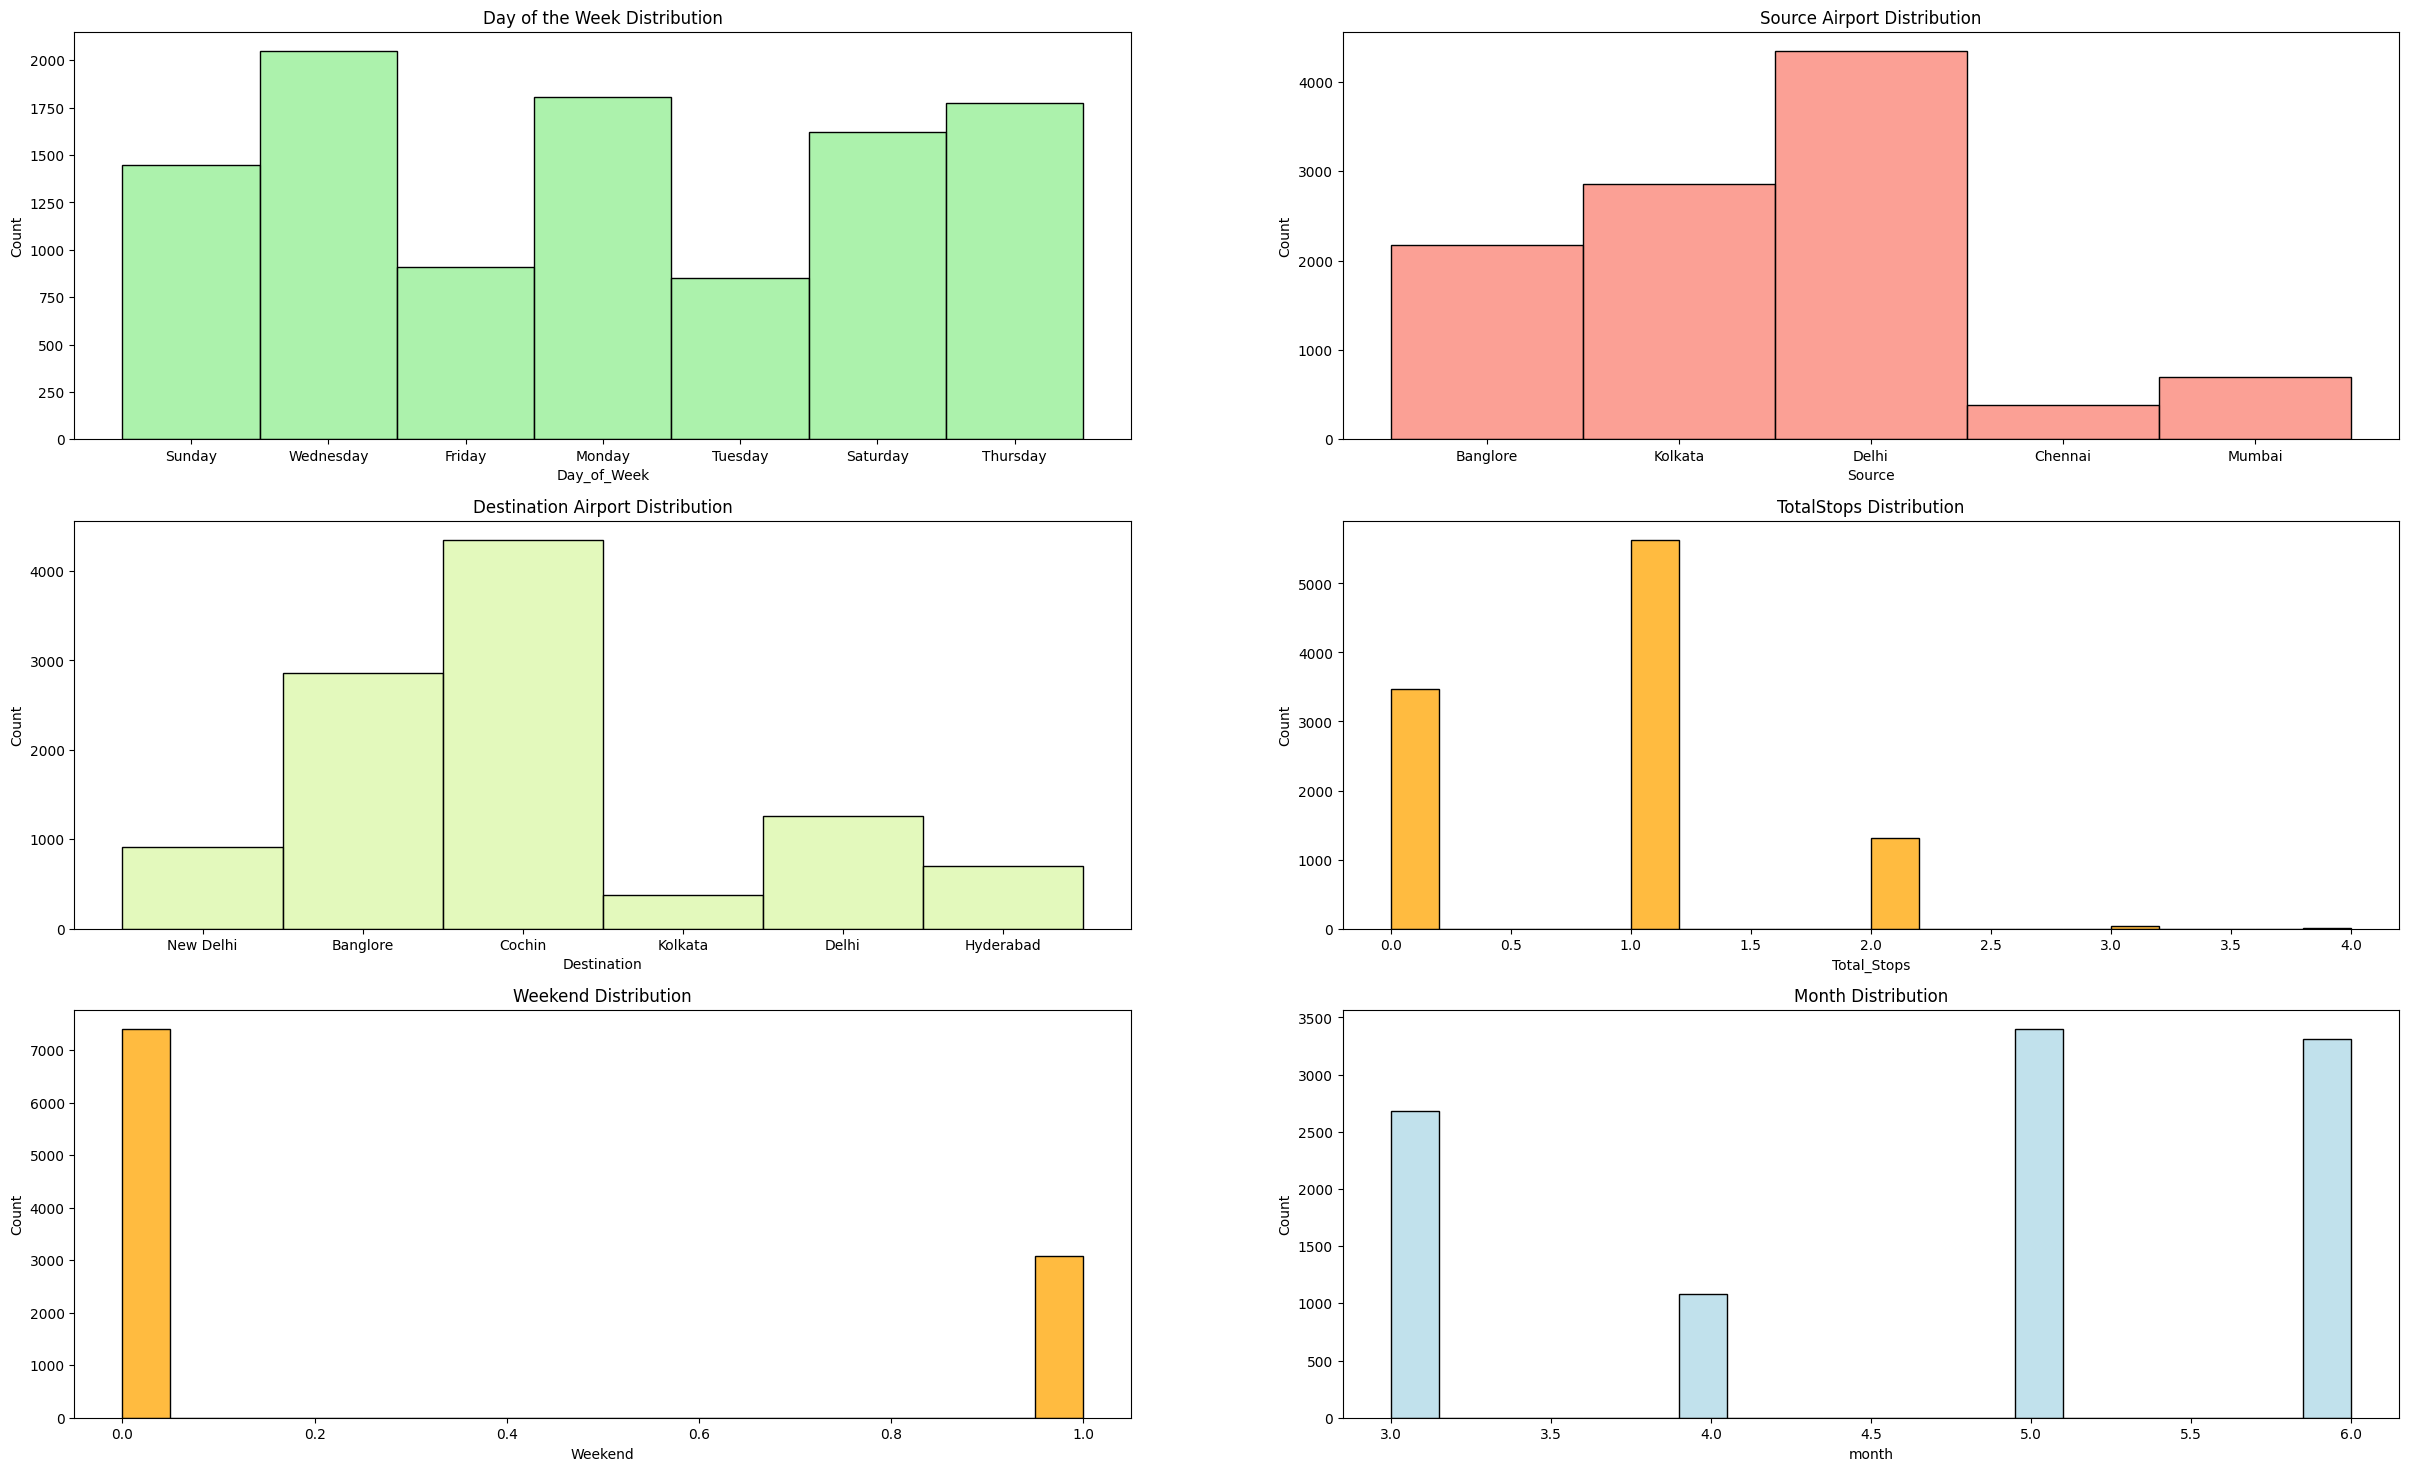

In [236]:
# Creating the subplots
fig, axes = plt.subplots(3, 2, figsize=(30, 18))  # 1 row, 3 columns

# Plotting each emotion

sns.histplot(df['Day_of_Week'], bins=20, kde=False, ax=axes[0,0], color='lightgreen')
axes[0,0].set_title('Day of the Week Distribution')

sns.histplot(df['Source'], bins=20, kde=False, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Source Airport Distribution')

sns.histplot(df['Destination'], bins=20, kde=False, ax=axes[1,0], color='#DAF7A6')
axes[1,0].set_title('Destination Airport Distribution')

sns.histplot(df['Total_Stops'], bins=20, kde=False, ax=axes[1,1], color='orange')
axes[1,1].set_title('TotalStops Distribution')

sns.histplot(df['Weekend'], bins=20, kde=False, ax=axes[2,0], color='orange')
axes[2,0].set_title('Weekend Distribution')

sns.histplot(df['month'], bins=20, kde=False, ax=axes[2,1], color='lightblue')
axes[2,1].set_title('Month Distribution')

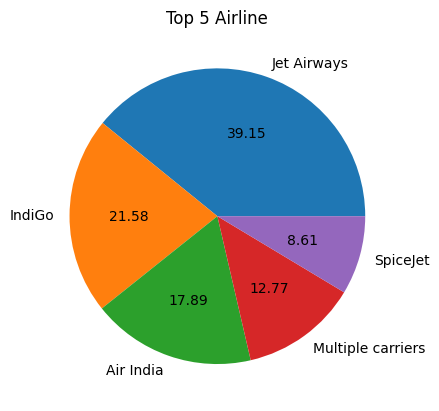

In [237]:
brand_counts = df['Airline'].value_counts()
top_5_brands = brand_counts.head(5)
df_top_5 = df[df['Airline'].isin(top_5_brands.index)]
plt.pie(top_5_brands, labels=top_5_brands.index, autopct='%.2f')
plt.title('Top 5 Airline')
plt.show()
     

In [238]:
df.sample(5)

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
8370,IndiGo,Banglore,Delhi,175,0.0,Thursday,0,18,4,0,30,3,25,4423
4887,Jet Airways,Delhi,Cochin,1270,1.0,Monday,0,24,6,21,50,19,0,10262
9701,Multiple carriers,Delhi,Cochin,630,1.0,Thursday,0,27,6,8,30,19,0,11200
7123,Multiple carriers,Delhi,Cochin,660,1.0,Wednesday,0,12,6,10,0,21,0,13587
2921,IndiGo,Mumbai,Hyderabad,85,0.0,Sunday,1,3,3,6,20,7,45,4784


(B) Numeriacl Values

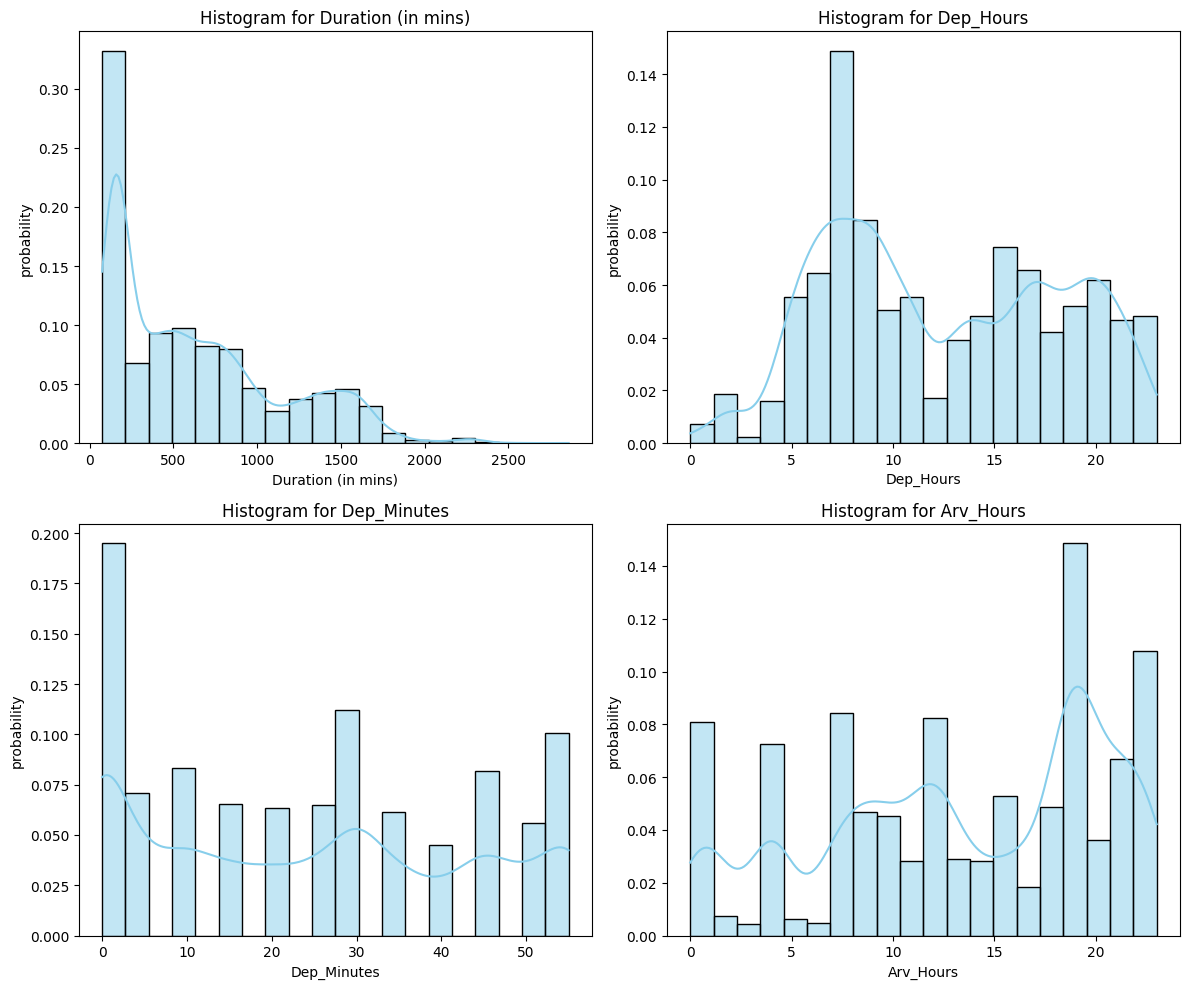

In [239]:
numeric_columns = ['Duration (in mins)','Dep_Hours', 'Dep_Minutes', 'Arv_Hours','Arv_Minutes','Price']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Plot histograms for numeric columns
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    sns.histplot(df[column], bins=20, kde=True, color='skyblue', ax=axes[i], stat = 'probability')
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('probability')

# Adjust layout
plt.tight_layout()
plt.show()

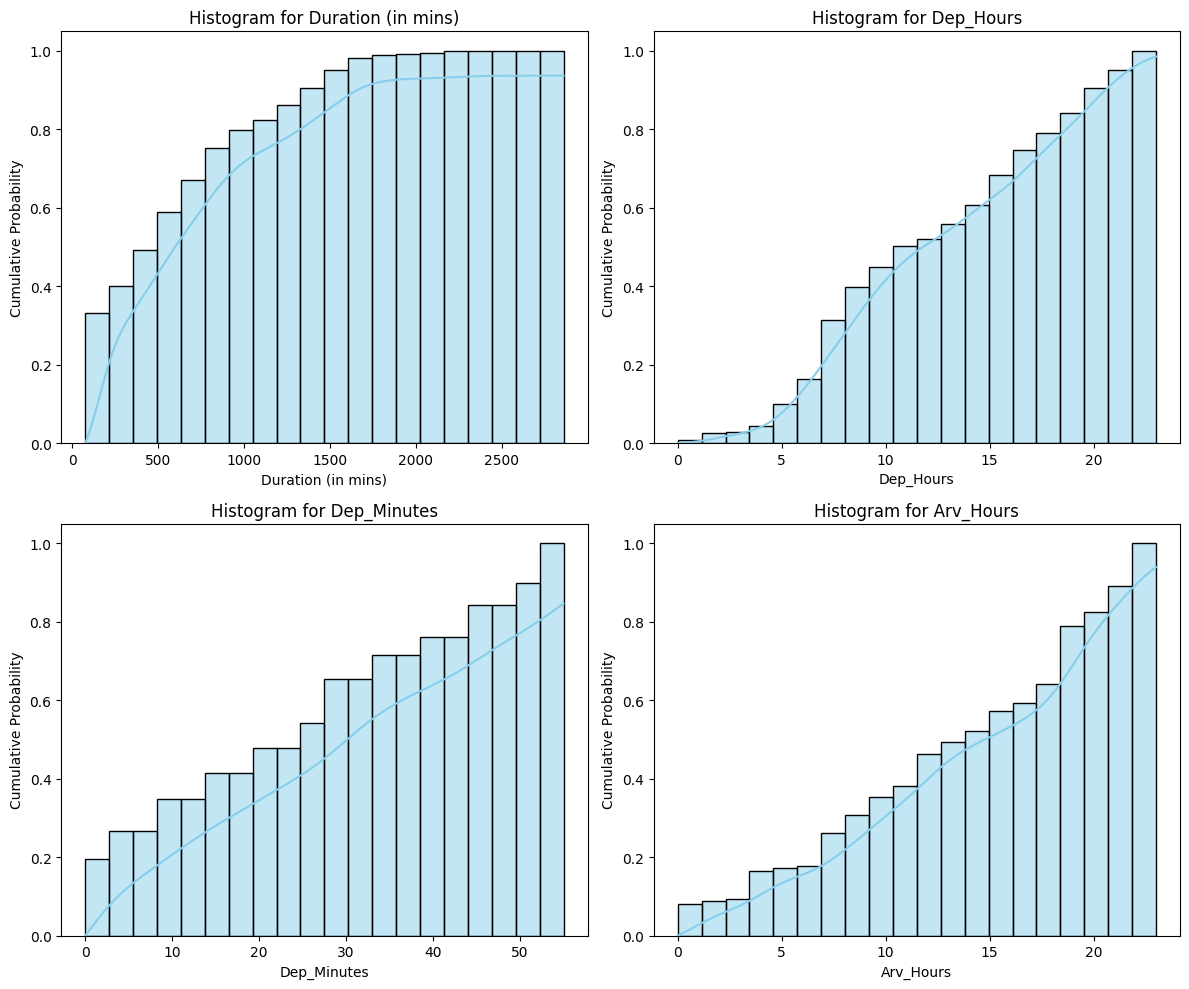

In [240]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Plot histograms for numeric columns with cumulative distribution function
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    sns.histplot(df[column], bins=20, kde=True, color='skyblue', ax=axes[i], stat='probability', cumulative=True)
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Cumulative Probability')

# Adjust layout
plt.tight_layout()
plt.show()


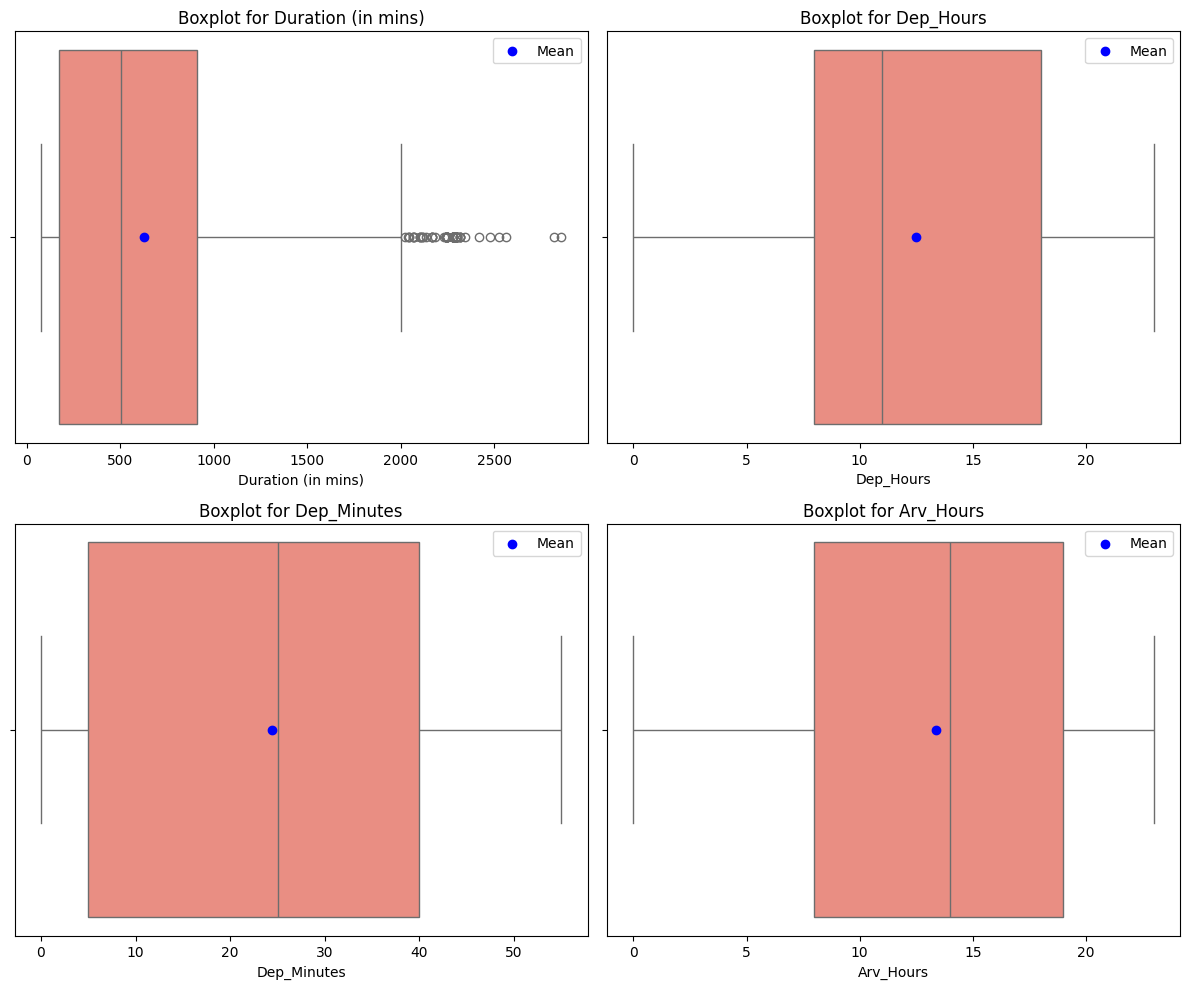

In [241]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# Iterate over numeric columns
for i, column in enumerate(numeric_columns[:4]):  # Considering the first 4 numeric columns for a 2x2 grid
    # Plot the boxplot
    sns.boxplot(x=df[column], color='salmon', ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

    # Identify outliers using IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Handle outliers by clipping values to the lower and upper bounds
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    # Plot mean as a point
    mean_point = axes[i].scatter(df[column].mean(), 0, color='blue', marker='o', label='Mean', zorder=5)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


#### Bivariate 

In [242]:
df.sample()

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
7750,Air India,Kolkata,Banglore,1830,2.0,Sunday,1,24,3,16,45,23,15,13885


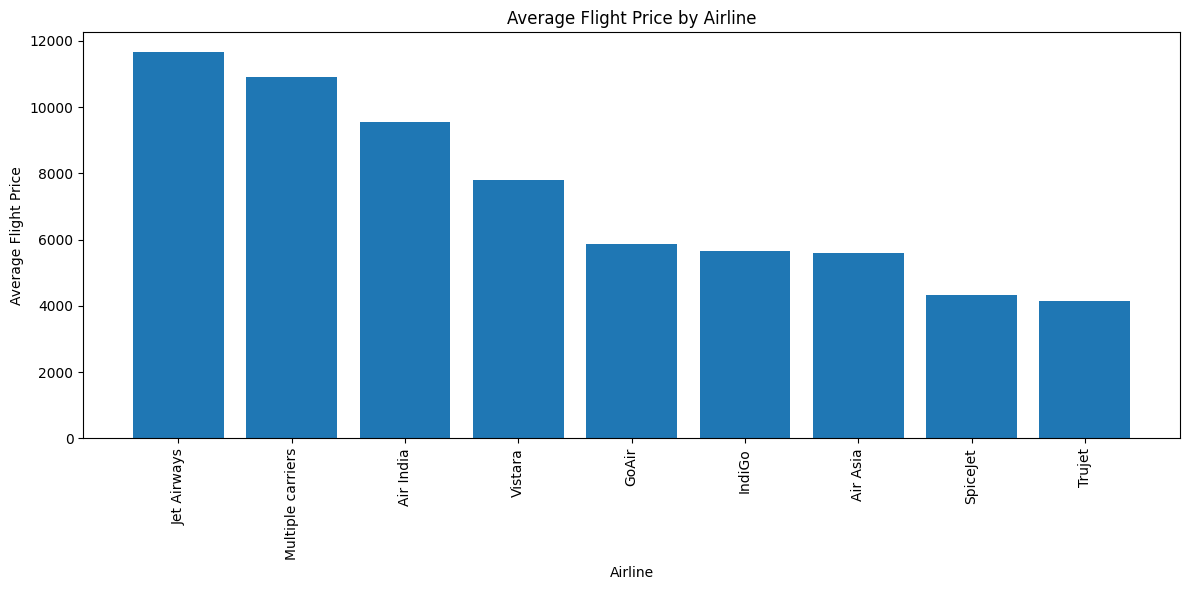

In [243]:
airline_prices = df.groupby('Airline')['Price'].mean().reset_index()        # grouping the mean price of each flight

# sorting the airlines by average price in decending order
airline_prices = airline_prices.sort_values(by="Price", ascending =False)

# Creating a bar chart
plt.figure(figsize=(12, 6))
plt.bar(airline_prices['Airline'], airline_prices['Price'])
plt.xlabel('Airline')
plt.ylabel('Average Flight Price')
plt.title('Average Flight Price by Airline')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

/tmp/ipykernel_717/2426826048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Weekend', 'Weekday'], y=[avg_price_weekend, avg_price_weekday], palette='pastel')


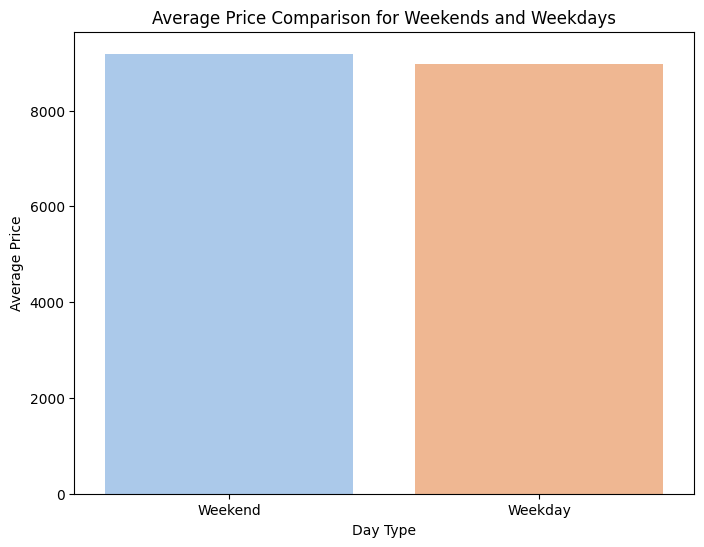

In [244]:
avg_price_weekend = df[df['Weekend'] == 1]['Price'].mean()
avg_price_weekday = df[df['Weekend'] == 0]['Price'].mean()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=['Weekend', 'Weekday'], y=[avg_price_weekend, avg_price_weekday], palette='pastel')
plt.title('Average Price Comparison for Weekends and Weekdays')
plt.xlabel('Day Type')
plt.ylabel('Average Price')
plt.show()

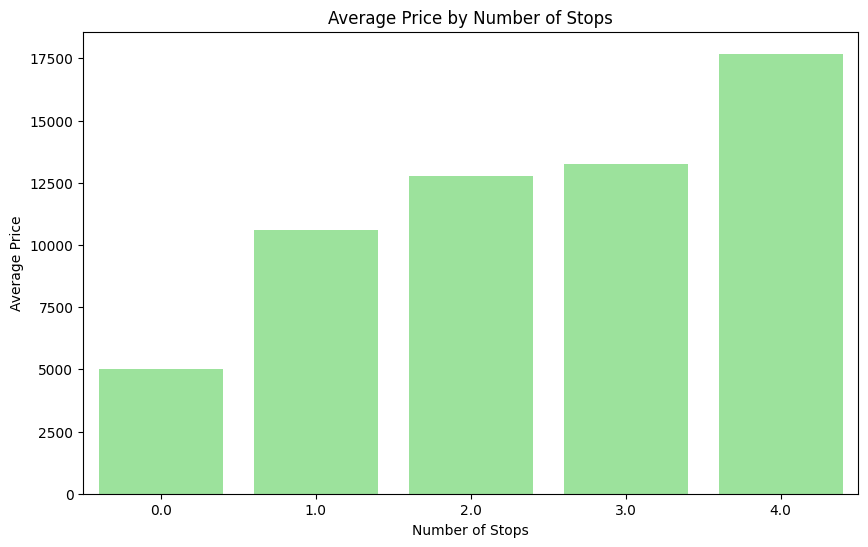

In [252]:
total_stops_by_prices = df.groupby('Total_Stops')['Price'].mean().reset_index()  

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Stops', y='Price', data=total_stops_by_prices, color='lightgreen')
plt.title('Average Price by Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Average Price')
plt.show()

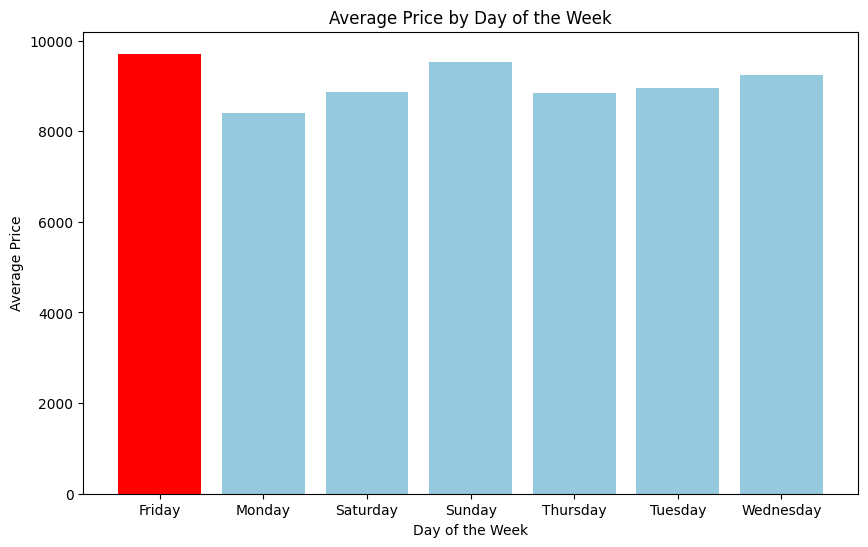

In [251]:
total_stops_by_prices = df.groupby('Day_of_Week')['Price'].mean().reset_index()

# Find the day with the highest average price
day_highest_avg_price = total_stops_by_prices.loc[total_stops_by_prices['Price'].idxmax(), 'Day_of_Week']

# Create a bar plot with the day with the highest average price in red
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='Price', data=total_stops_by_prices, color='skyblue')
plt.title('Average Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price')

# Highlight the bar for the day with the highest average price in red
plt.bar(total_stops_by_prices[total_stops_by_prices['Day_of_Week'] == day_highest_avg_price].index,
        total_stops_by_prices[total_stops_by_prices['Day_of_Week'] == day_highest_avg_price]['Price'],
        color='red')

plt.show()


In [248]:
df.sample()

,Airline,Source,Destination,Duration (in mins),Total_Stops,Day_of_Week,Weekend,Day,month,Dep_Hours,Dep_Minutes,Arv_Hours,Arv_Minutes,Price
1820,Vistara,Banglore,Delhi,170,0.0,Tuesday,0,9,4,9,45,12,35,5403


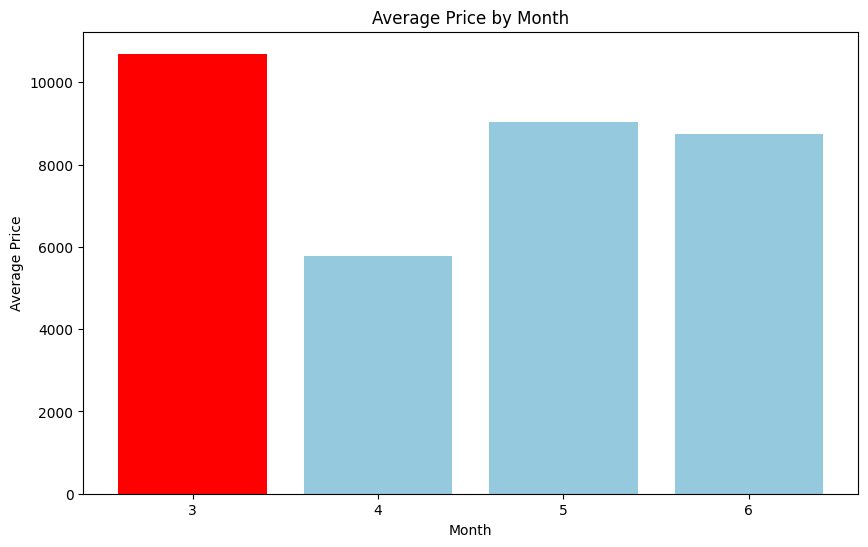

In [255]:
total_stops_by_prices = df.groupby('month')['Price'].mean().reset_index()

# Find the day with the highest average price
day_highest_avg_price = total_stops_by_prices.loc[total_stops_by_prices['Price'].idxmax(), 'month']

# Create a bar plot with the day with the highest average price in red
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Price', data=total_stops_by_prices, color='skyblue')
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Highlight the bar for the day with the highest average price in red
plt.bar(total_stops_by_prices[total_stops_by_prices['month'] == day_highest_avg_price].index,
        total_stops_by_prices[total_stops_by_prices['month'] == day_highest_avg_price]['Price'],
        color='red')

plt.show()
